# Imports for Simulation and Visualiation

In [2]:
from random import randint, shuffle
import time
import matplotlib.pyplot as plt
import numpy as np

### Class Game
- Attributes
    - PayoffMatrix
        : Payoff Matrix of two player Game
- Methods
    - findSDSE
        : Computes Strong Dominant Strategy Equilibrium if it exists.
    - findMSNE
        : Computes MSNE using indifference priciple.

In [3]:
class game:
    def __init__(self):
        food = (MAX_FOOD_PER_ROUND + MIN_FOOD_PER_ROUND)//2
        self.payoffMatrix = [ 
                            [[(food//2) - ENERGY_LOSS_FROM_FIGHTING, (food//2) - ENERGY_LOSS_FROM_FIGHTING],[food,0]],
                            [[0, food],[(food//2), (food//2)]]
                            ]
#     Arguments : None, Return: list of SDSE strategy
    def findSDSE(self):
        P1 = []
        P2 = []
        if self.payoffMatrix[0][0][0] > self.payoffMatrix[1][0][0] and self.payoffMatrix[0][1][0] > self.payoffMatrix[1][1][0]:
            P1.append(0)
        if self.payoffMatrix[0][0][0] < self.payoffMatrix[1][0][0] and self.payoffMatrix[0][1][0] < self.payoffMatrix[1][1][0]:
            P1.appendp(1)
        if self.payoffMatrix[0][0][1] > self.payoffMatrix[0][1][1] and self.payoffMatrix[1][0][1] > self.payoffMatrix[1][1][1]:
            P2.append(0)
        if self.payoffMatrix[0][0][1] < self.payoffMatrix[0][1][1] and self.payoffMatrix[1][0][1] < self.payoffMatrix[1][1][1]:
            P2.append(1)
        ret = [(x, y) for x in P1 for y in P2]
        return ret

#   Arguments: None, Return list of probability distribution over strategy for player 1 and player 2
    def findMSNE(self):

        SDSE = self.findSDSE()
        p = np.zeros(2)
        q = np.zeros(2)
        if(len(SDSE) > 0):
            p[SDSE[0][0]] = 1
            q[SDSE[0][1]] = 1
            return [p,q]
        
#         row player Indifference Condition
        a = np.array([[1, 1], [self.payoffMatrix[0][0][0] - self.payoffMatrix[1][0][0], self.payoffMatrix[0][1][0] - self.payoffMatrix[1][1][0]] ])
        b = np.array([1, 0])
        q = np.linalg.solve(a, b)
        
#         col player Indifference Condition
        a = np.array([[1, 1], [self.payoffMatrix[0][0][1] - self.payoffMatrix[0][1][1], self.payoffMatrix[1][0][1] - self.payoffMatrix[1][1][1]] ])
        b = np.array([1, 0])
        p = np.linalg.solve(a, b) 
        return [p,q]
        

#### Global intitial Condtion
1. STARTING_DOVES
    : The number of players who are Doves in the beginning
2. STARTING_HAWKS
    : The number of players who are Hawks in the beginning
3. ROUNDS
    : Number of Rounds in the simulation
4. STARTING_ENERGY
    : The amount of energy with which each player starts the game.
5. MIN_FOOD_PER_ROUND
    : Min energy available per food.
6. MAX_FOOD_PER_ROUND
    : Max energy available per food.
7. MAX_FOOD_APPEARANCE
    : Max number of food appearance per round
8. ENERGY_REQUIRED_FOR_REPRODUCTION
    : Minimum energy required to reproduce
9. ENERGY_LOSS_PER_ROUND
    : Energy spent for surviving a round
10. ENERGY_LOSS_FROM_FIGHTING
    : Energy spent over fighting
11. ENERGY_REQUIRED_FOR_LIVING
    : Minimum energy required to remain alive
    
#### Model Formulation

1. Game Starts with gameInit(), a function which initialize all the agents. These agents are the players in this game and they can be either HAWK or DOVE. 
2. Then rounds start, while rounds <= ROUNDS **and** Agents Remaining >=2:
    1. Call AwakenAgents(), set the state of agent to **Awake State**.
    2. Generate the random food for the current round.
    3. Shuffle the agents for random pairing.
    4. Then pair the agents and let them compete over the food, However the max number of food appearance is limited by MAX_FOOD_APPEARANCE.
    5. Then the agents pay the cost of living a round.
    6. Cull() is called and every agent with energy less than ENERGY_REQUIRED_FOR_LIVING is deleted from the simulation.
    7. The remaing of the agents then reproduce if they have energy greater than ENERGY_REQUIRED_FOR_REPRODUCTION.
    8. Data is collected stored for further analysis.
    9. Agents Sent to sleet State.
3. After the simulation ends we analyze and compare the data collected with the  theoretically calculated MSNE.
    

In [53]:
STARTING_DOVES = 1000
STARTING_HAWKS = 1000
STARTING_POPULATION = STARTING_HAWKS + STARTING_DOVES

ROUNDS = 200
STARTING_ENERGY = 100

MIN_FOOD_PER_ROUND = 40
MAX_FOOD_PER_ROUND = 40
MAX_FOOD_APPEARANCE = 1000 # this tells how much max food can be found
ENERGY_REQUIRED_FOR_REPRODUCTION = 250
ENERGY_LOSS_PER_ROUND = 4
ENERGY_LOSS_FROM_FIGHTING = 60
ENERGY_REQUIRED_FOR_LIVING = 10

STATUS_ACTIVE = "active"
STATUS_ASLEEP = "asleep"

TYPE_HAWK = "hawk"
TYPE_DOVE = "dove"

agents = []

# Graph stuff
graph_hawk_points = []
graph_dove_points = []

AGENT_ID = 1
class Agent:
    
    def __init__(self, agent_type, status, energy):
        global AGENT_ID
        self.id = AGENT_ID
        AGENT_ID += 1
        self.agent_type = agent_type
        self.status = status
        self.energy = energy
    def wake(self):
        self.status = STATUS_ACTIVE
    def sleep(self):
        self.status = STATUS_ASLEEP

def gameInit():
    global agents
    agents = []
    for x in range(0,STARTING_DOVES):
        a = Agent(TYPE_DOVE, STATUS_ASLEEP, STARTING_ENERGY)
        agents.append(a)
    for x in range(0,STARTING_HAWKS):
        a = Agent(TYPE_HAWK, STATUS_ASLEEP, STARTING_ENERGY)
        agents.append(a)

def compete(agent, nemesis, food):
# add a food fuction inside agent
    if agent.agent_type == TYPE_HAWK and nemesis.agent_type == TYPE_HAWK:
        # food distributed as food // 2 and loss from fighting subtracted
        agent.energy += (food//2)
        agent.energy -= ENERGY_LOSS_FROM_FIGHTING
        nemesis.energy += (food//2)
        nemesis.energy -= ENERGY_LOSS_FROM_FIGHTING
        
    if agent.agent_type == TYPE_HAWK and nemesis.agent_type == TYPE_DOVE:
        agent.energy += food

    if agent.agent_type == TYPE_DOVE and nemesis.agent_type == TYPE_HAWK:
        nemesis.energy += food

    if agent.agent_type == TYPE_DOVE and nemesis.agent_type == TYPE_DOVE:
        agent.energy += (food//2)
        nemesis.energy += (food//2)

    nemesis.sleep()
    agent.sleep()
def cull():

    dead_hawks = 0
    dead_doves = 0
    n = len(agents)
    for index, agent in enumerate(reversed(agents)):
        if agent.energy < ENERGY_REQUIRED_FOR_LIVING:
            if agent.agent_type == TYPE_DOVE: dead_doves += 1
            if agent.agent_type == TYPE_HAWK: dead_hawks += 1
            del agents[n - index - 1]


    return dead_hawks, dead_doves
def breed():
    """
    If agent can breed, it halves its energy and produces 
    one baby with starting energy (parent energy // 2) and
    keep parent energy // 2 for itself
    """
    hawk_babies = 0
    dove_babies = 0
    for agent in agents:
        if agent.energy > ENERGY_REQUIRED_FOR_REPRODUCTION:
            baby_agent_a = Agent(agent.agent_type, STATUS_ASLEEP, (agent.energy//2))
            agents.append(baby_agent_a)

            agent.energy //= 2

            if agent.agent_type == TYPE_DOVE: dove_babies += 1
            if agent.agent_type == TYPE_HAWK: hawk_babies += 1


    return hawk_babies, dove_babies
def getCountOfType(agents):
    local_hawk_count = 0
    local_dove_count = 0
    for agent in agents:
        if agent.agent_type == TYPE_HAWK:
            local_hawk_count += 1
        else:
            local_dove_count += 1
    return local_hawk_count, local_dove_count
def getFood():
    return randint(MIN_FOOD_PER_ROUND, MAX_FOOD_PER_ROUND)
def awakenAgents():
    for agent in agents:
        agent.wake()
def SendToSleep():
    for agent in agents:
        agent.sleep()
def main():
    gameInit()

    current_round = 1
    death_count = 0
    dead_hawks  = 0
    dead_doves  = 0
    breed_count = 0
    main_tic = time.time()
    
    while current_round <= ROUNDS and len(agents) > 2:
        print(f"Round {current_round}")
        tic = time.time()
        awakenAgents()
        food = getFood()
# shuffling agents so that the matchmaking while be random
        shuffle(agents)
        for idx in range (0, len(agents), 2):
            if idx//2 > MAX_FOOD_APPEARANCE:
                break
            if idx + 1 >= len(agents):
                break
            agent, nemesis = agents[idx], agents[idx + 1]
            compete(agent, nemesis, food)

        # Energy cost of 'living'
        for agent in agents:
            agent.energy -= ENERGY_LOSS_PER_ROUND
        
        round_dead_hawks, round_dead_doves = cull()
        round_hawk_babies, round_dove_babies = breed()
        death_count += (round_dead_hawks + round_dead_doves)
        breed_count += (round_hawk_babies + round_dove_babies)
        SendToSleep()

        toc = time.time()
        # Plot
        hawk_count, dove_count = getCountOfType(agents)
        hawk_percent = (hawk_count / (hawk_count + dove_count))*100
        dove_percent = (dove_count / (hawk_count + dove_count))*100
        graph_hawk_points.append(hawk_count)
        graph_dove_points.append(dove_count)
        print("ROUND %d" % current_round)
        print("Food produced          : %d" % food)
        print(f"Population             : Hawks-> {hawk_count}, Doves-> {dove_count}")
        print("Dead hawks             : %d" % round_dead_hawks)
        print("Dead doves             : %d" % round_dead_doves)
        print("Hawk babies            : %s" % round_hawk_babies)
        print("Dove babies            : %s" % round_dove_babies)
        print("Hawks                  : %s" % hawk_percent)
        print("Doves                  : %s" % dove_percent)
        print("----")
        print("Round Processing time  : %s" % (toc - tic))
        print("Elapsed time           : %s\n" % (time.time() - main_tic))

        

        current_round += 1


    main_toc = time.time()
    hawk_count, dove_count = getCountOfType(agents)
    hawk_percent = (hawk_count / (hawk_count + dove_count))*100
    dove_percent = (dove_count / (hawk_count + dove_count))*100
    print("=============================================================")
    print("Total dead agents      : %d" % death_count)
    print("Total breeding agents  : %d" % breed_count)
    print("Total rounds completed : %d" % (current_round - 1))
    print("Total population size  : %s" % len(agents))
    print("Hawks                  : %s" % hawk_percent)
    print("Doves                  : %s" % dove_percent)
    print("Processing time        : %s" % (main_toc - main_tic))
    print("=============================================================")
main()


Round 1
ROUND 1
Food produced          : 40
Population             : Hawks-> 1000, Doves-> 1000
Dead hawks             : 0
Dead doves             : 0
Hawk babies            : 0
Dove babies            : 0
Hawks                  : 50.0
Doves                  : 50.0
----
Round Processing time  : 0.00498652458190918
Elapsed time           : 0.005983591079711914

Round 2
ROUND 2
Food produced          : 40
Population             : Hawks-> 1000, Doves-> 1000
Dead hawks             : 0
Dead doves             : 0
Hawk babies            : 0
Dove babies            : 0
Hawks                  : 50.0
Doves                  : 50.0
----
Round Processing time  : 0.004987001419067383
Elapsed time           : 0.01196742057800293

Round 3
ROUND 3
Food produced          : 40
Population             : Hawks-> 1000, Doves-> 1000
Dead hawks             : 0
Dead doves             : 0
Hawk babies            : 0
Dove babies            : 0
Hawks                  : 50.0
Doves                  : 50.0
----
Round Pro

ROUND 23
Food produced          : 40
Population             : Hawks-> 2376, Doves-> 1026
Dead hawks             : 0
Dead doves             : 0
Hawk babies            : 43
Dove babies            : 0
Hawks                  : 69.84126984126983
Doves                  : 30.158730158730158
----
Round Processing time  : 0.007978677749633789
Elapsed time           : 0.18650054931640625

Round 24
ROUND 24
Food produced          : 40
Population             : Hawks-> 2435, Doves-> 1028
Dead hawks             : 0
Dead doves             : 0
Hawk babies            : 59
Dove babies            : 2
Hawks                  : 70.31475599191452
Doves                  : 29.685244008085476
----
Round Processing time  : 0.00797891616821289
Elapsed time           : 0.19547677040100098

Round 25
ROUND 25
Food produced          : 40
Population             : Hawks-> 2483, Doves-> 1032
Dead hawks             : 0
Dead doves             : 0
Hawk babies            : 48
Dove babies            : 4
Hawks                

ROUND 61
Food produced          : 40
Population             : Hawks-> 3625, Doves-> 988
Dead hawks             : 4
Dead doves             : 4
Hawk babies            : 21
Dove babies            : 0
Hawks                  : 78.58226750487752
Doves                  : 21.41773249512248
----
Round Processing time  : 0.009973526000976562
Elapsed time           : 0.580446720123291

Round 62
ROUND 62
Food produced          : 40
Population             : Hawks-> 3640, Doves-> 984
Dead hawks             : 4
Dead doves             : 4
Hawk babies            : 19
Dove babies            : 0
Hawks                  : 78.719723183391
Doves                  : 21.280276816608996
----
Round Processing time  : 0.009973287582397461
Elapsed time           : 0.5914170742034912

Round 63
ROUND 63
Food produced          : 40
Population             : Hawks-> 3650, Doves-> 944
Dead hawks             : 4
Dead doves             : 40
Hawk babies            : 14
Dove babies            : 0
Hawks                  : 79.

ROUND 100
Food produced          : 40
Population             : Hawks-> 3331, Doves-> 401
Dead hawks             : 40
Dead doves             : 0
Hawk babies            : 8
Dove babies            : 0
Hawks                  : 89.2550911039657
Doves                  : 10.744908896034298
----
Round Processing time  : 0.008980751037597656
Elapsed time           : 1.0293912887573242

Round 101
ROUND 101
Food produced          : 40
Population             : Hawks-> 3293, Doves-> 398
Dead hawks             : 41
Dead doves             : 3
Hawk babies            : 3
Dove babies            : 0
Hawks                  : 89.21701435925223
Doves                  : 10.782985640747764
----
Round Processing time  : 0.008975744247436523
Elapsed time           : 1.0383670330047607

Round 102
ROUND 102
Food produced          : 40
Population             : Hawks-> 3264, Doves-> 396
Dead hawks             : 34
Dead doves             : 2
Hawk babies            : 5
Dove babies            : 0
Hawks                

Doves                  : 0.0
----
Round Processing time  : 0.0009999275207519531
Elapsed time           : 1.4313099384307861

Round 159
ROUND 159
Food produced          : 40
Population             : Hawks-> 439, Doves-> 0
Dead hawks             : 38
Dead doves             : 0
Hawk babies            : 0
Dove babies            : 0
Hawks                  : 100.0
Doves                  : 0.0
----
Round Processing time  : 0.0019979476928710938
Elapsed time           : 1.4333078861236572

Round 160
ROUND 160
Food produced          : 40
Population             : Hawks-> 406, Doves-> 0
Dead hawks             : 33
Dead doves             : 0
Hawk babies            : 0
Dove babies            : 0
Hawks                  : 100.0
Doves                  : 0.0
----
Round Processing time  : 0.000993490219116211
Elapsed time           : 1.435307264328003

Round 161
ROUND 161
Food produced          : 40
Population             : Hawks-> 391, Doves-> 0
Dead hawks             : 15
Dead doves             : 0
H

In [54]:
npdove = np.array(graph_dove_points)
nphawk = np.array(graph_hawk_points)
npdovePer = npdove / (npdove + nphawk)
nphawkPer = nphawk / (npdove + nphawk)
nppopulation = nphawk + npdove
nppopulation = nppopulation/np.max(nppopulation)

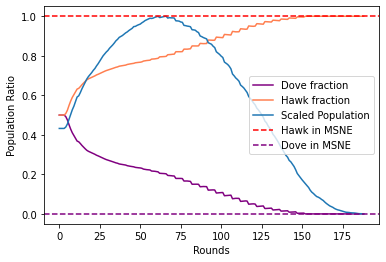

In [55]:
plt.clf()
plt.plot(npdovePer, color = "purple", label = "Dove fraction")
plt.plot(nphawkPer, color = "coral", label = "Hawk fraction")
plt.plot(nppopulation, label = "Scaled Population")
MSNE = game().findMSNE()
plt.axhline(y=MSNE[0][0],color = 'red', linestyle='--', label = "Hawk in MSNE")
plt.axhline(y=MSNE[0][1],color = 'purple', linestyle='--', label = "Dove in MSNE")
plt.legend()
plt.xlabel("Rounds")
plt.ylabel("Population Ratio")


plt.show()

In [50]:
print(MSNE)

[array([0.33333333, 0.66666667]), array([0.33333333, 0.66666667])]


In [122]:
STARTING_DOVES = 1000
STARTING_HAWKS = 1000
STARTING_POPULATION = STARTING_HAWKS + STARTING_DOVES

ROUNDS = 500
STARTING_ENERGY = 100

MIN_FOOD_PER_ROUND = 10
MAX_FOOD_PER_ROUND = 70
MAX_FOOD_APPEARANCE = 2000 # this tells how much max food can be found
ENERGY_REQUIRED_FOR_REPRODUCTION = 250
ENERGY_LOSS_PER_ROUND = 4
ENERGY_LOSS_FROM_FIGHTING = 35
ENERGY_REQUIRED_FOR_LIVING = 10

In [ ]:
## case 1 in ppt
STARTING_DOVES = 1000
STARTING_HAWKS = 1000
STARTING_POPULATION = STARTING_HAWKS + STARTING_DOVES

ROUNDS = 200
STARTING_ENERGY = 100

MIN_FOOD_PER_ROUND = 40
MAX_FOOD_PER_ROUND = 40
MAX_FOOD_APPEARANCE = 1000 # this tells how much max food can be found
ENERGY_REQUIRED_FOR_REPRODUCTION = 250
ENERGY_LOSS_PER_ROUND = 4
ENERGY_LOSS_FROM_FIGHTING = 10
ENERGY_REQUIRED_FOR_LIVING = 10


# case 2 in ppt
STARTING_DOVES = 1000
STARTING_HAWKS = 1000
STARTING_POPULATION = STARTING_HAWKS + STARTING_DOVES

ROUNDS = 200
STARTING_ENERGY = 100

MIN_FOOD_PER_ROUND = 40
MAX_FOOD_PER_ROUND = 40
MAX_FOOD_APPEARANCE = 1000 # this tells how much max food can be found
ENERGY_REQUIRED_FOR_REPRODUCTION = 250
ENERGY_LOSS_PER_ROUND = 4
ENERGY_LOSS_FROM_FIGHTING = 25
ENERGY_REQUIRED_FOR_LIVING = 10

# case 3 in ppt
STARTING_DOVES = 1000
STARTING_HAWKS = 1000
STARTING_POPULATION = STARTING_HAWKS + STARTING_DOVES

ROUNDS = 200
STARTING_ENERGY = 100

MIN_FOOD_PER_ROUND = 40
MAX_FOOD_PER_ROUND = 40
MAX_FOOD_APPEARANCE = 1000 # this tells how much max food can be found
ENERGY_REQUIRED_FOR_REPRODUCTION = 250
ENERGY_LOSS_PER_ROUND = 4
ENERGY_LOSS_FROM_FIGHTING = 20
ENERGY_REQUIRED_FOR_LIVING = 10

# case 4
STARTING_DOVES = 1000
STARTING_HAWKS = 1000
STARTING_POPULATION = STARTING_HAWKS + STARTING_DOVES

ROUNDS = 200
STARTING_ENERGY = 100

MIN_FOOD_PER_ROUND = 40
MAX_FOOD_PER_ROUND = 40
MAX_FOOD_APPEARANCE = 1000 # this tells how much max food can be found
ENERGY_REQUIRED_FOR_REPRODUCTION = 250
ENERGY_LOSS_PER_ROUND = 4
ENERGY_LOSS_FROM_FIGHTING = 60
ENERGY_REQUIRED_FOR_LIVING = 10